<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/Attention_%3D_Kernel_Smoothing_Mathematical_Proof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Attention shape: torch.Size([12, 8, 8])
Sequence length: 8


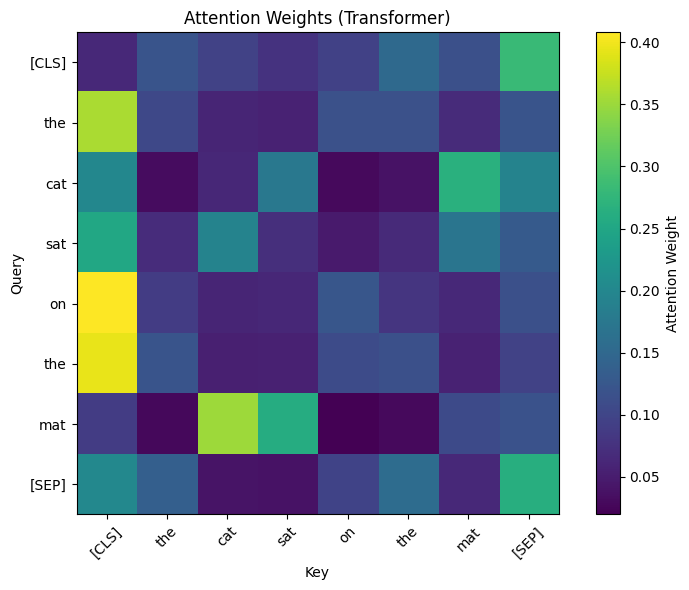


Attention weights sum per row (should be 1.0):
[1. 1. 1. 1. 1. 1. 1. 1.]

Manual computation matches model: False

Nadaraya-Watson output shape: (8, 64)
Attention output shape: (8, 64)
Outputs match: True


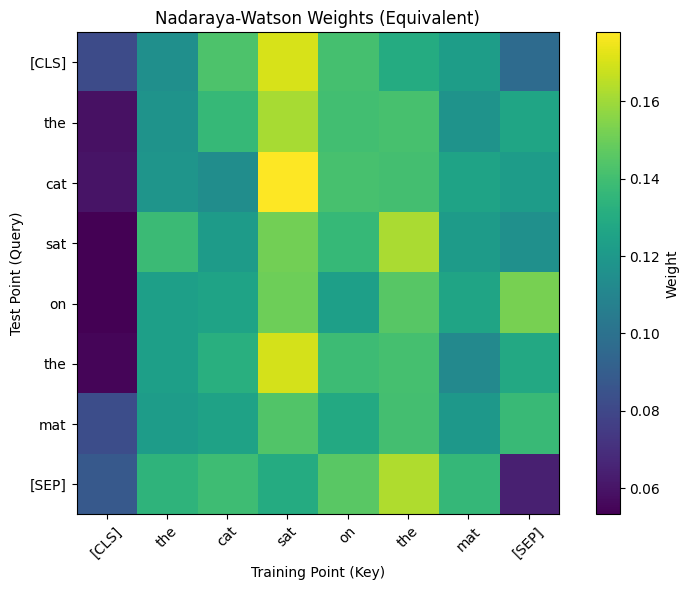


Weights match: True


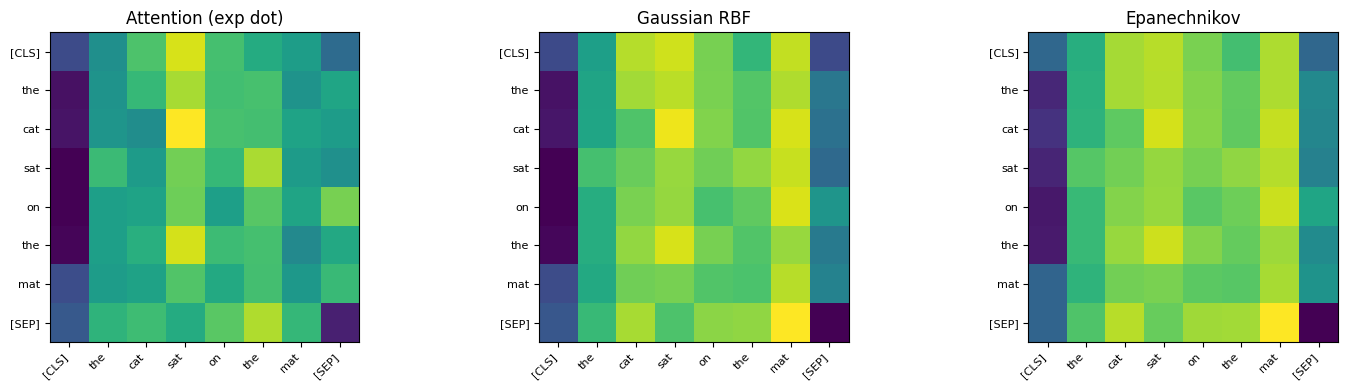

/tmp/ipython-input-3345692139.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


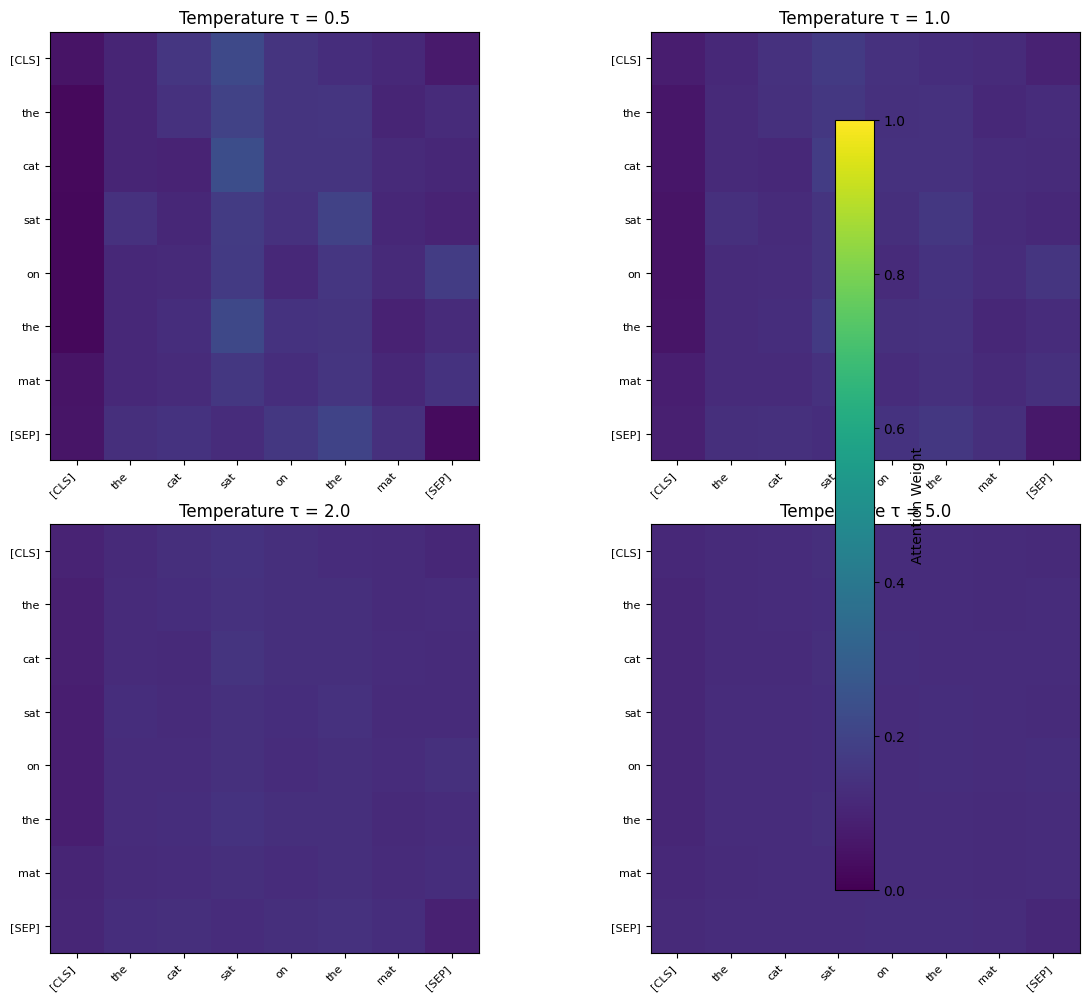


Entropy of attention distribution (higher = more uniform):
τ = 0.5: Entropy = 1.992
τ = 1.0: Entropy = 2.050
τ = 2.0: Entropy = 2.071
τ = 5.0: Entropy = 2.078


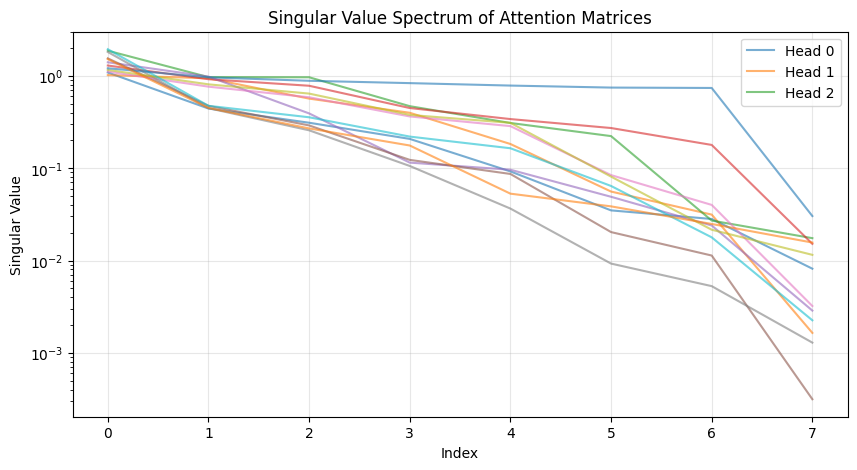


Effective rank (σ > 0.01σ_max): [np.int64(7), np.int64(7), np.int64(7), np.int64(8), np.int64(7), np.int64(6), np.int64(7), np.int64(5), np.int64(7), np.int64(6), np.int64(8), np.int64(8)]
Mean effective rank: 6.9/8


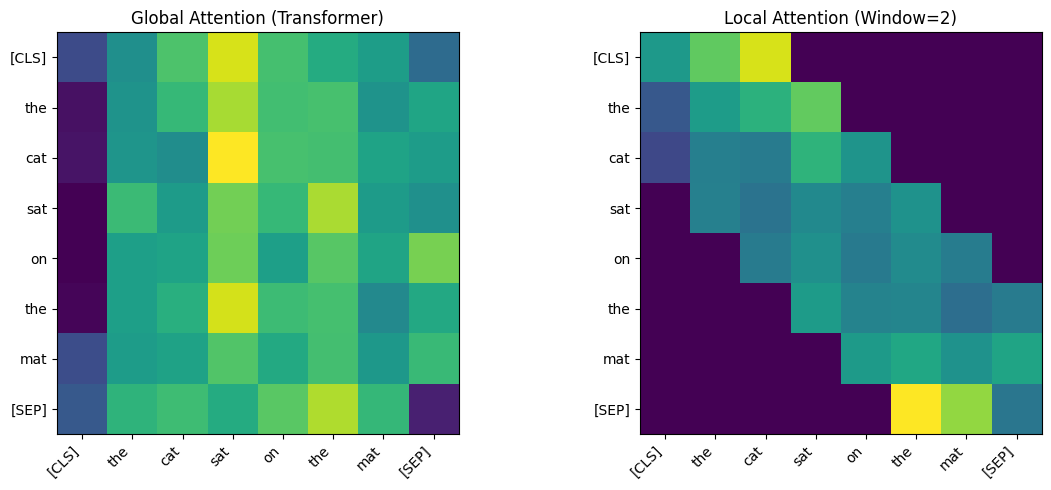


Mathematical Properties Verification

1. Attention weights sum to 1 (probability distribution):
   Min: 1.000000, Max: 1.000000
   All ≈ 1.0: True

2. Attention output is convex combination of values:
   Output shape: (8, 64)
   Output = weighted avg of V: True

3. Dot product kernel properties:
   Q·K shape: torch.Size([8, 8])
   Symmetric: False
   Scale factor: √d = √64 = 8.00

4. Nadaraya-Watson equivalence:
   NW weights ≡ Attention weights: True
   NW output ≡ Attention output: True

5. Temperature as kernel bandwidth:
   τ= 0.1: Max weight = 0.538 (lower τ = sharper)
   τ= 1.0: Max weight = 0.163 (lower τ = sharper)
   τ=10.0: Max weight = 0.129 (lower τ = sharper)



In [1]:
!pip install -q transformers torch numpy matplotlib scipy

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from transformers import AutoModel, AutoTokenizer

# Load small open-source transformer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Example sequence
text = "The cat sat on the mat"
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # Tuple of attention weights per layer

# Extract first layer attention (12 heads, seq_len x seq_len)
attn_layer0 = attentions[0][0]  # Shape: [12, seq_len, seq_len]
print(f"Attention shape: {attn_layer0.shape}")
print(f"Sequence length: {attn_layer0.shape[1]}")

# Visualize attention from head 0
attn_head0 = attn_layer0[0].numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

plt.figure(figsize=(8, 6))
plt.imshow(attn_head0, cmap='viridis')
plt.colorbar(label='Attention Weight')
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.xlabel('Key')
plt.ylabel('Query')
plt.title('Attention Weights (Transformer)')
plt.tight_layout()
plt.savefig('transformer_attention.png', dpi=150)
plt.show()

print("\nAttention weights sum per row (should be 1.0):")
print(attn_head0.sum(axis=1))

# Manual attention computation
hidden_size = 768
head_dim = hidden_size // 12
embeddings = outputs.last_hidden_state[0]  # [seq_len, 768]

# Extract Q, K, V weights from model
layer0 = model.transformer.layer[0].attention
Wq = layer0.q_lin.weight.data[:head_dim, :]  # First head
Wk = layer0.k_lin.weight.data[:head_dim, :]
Wv = layer0.v_lin.weight.data[:head_dim, :]

Q = embeddings @ Wq.T  # [seq_len, head_dim]
K = embeddings @ Wk.T
V = embeddings @ Wv.T

# Compute attention manually
scale = np.sqrt(head_dim)
scores = Q @ K.T / scale  # [seq_len, seq_len]
attn_manual = torch.softmax(scores, dim=-1).numpy()

print(f"\nManual computation matches model: {np.allclose(attn_manual, attn_head0, atol=1e-5)}")

# Now implement Nadaraya-Watson with same kernel
def nadaraya_watson(X_train, y_train, X_test, kernel_func):
    n_test = X_test.shape[0]
    n_train = X_train.shape[0]
    predictions = np.zeros((n_test, y_train.shape[1]))
    weights_all = np.zeros((n_test, n_train))

    for i in range(n_test):
        # Compute kernel similarities
        similarities = np.array([kernel_func(X_test[i], X_train[j]) for j in range(n_train)])

        # Normalize to weights
        weights = similarities / similarities.sum()
        weights_all[i] = weights

        # Weighted average
        predictions[i] = (weights.reshape(-1, 1) * y_train).sum(axis=0)

    return predictions, weights_all

# Define exponential dot-product kernel (same as attention)
def attention_kernel(q, k, scale=1.0):
    return np.exp(np.dot(q, k) / scale)

# Apply Nadaraya-Watson with attention kernel
Q_np = Q.numpy()
K_np = K.numpy()
V_np = V.numpy()

nw_output, nw_weights = nadaraya_watson(K_np, V_np, Q_np,
                                         lambda q, k: attention_kernel(q, k, scale))

print(f"\nNadaraya-Watson output shape: {nw_output.shape}")
print(f"Attention output shape: {(attn_manual @ V.numpy()).shape}")
print(f"Outputs match: {np.allclose(nw_output, attn_manual @ V.numpy(), atol=1e-5)}")

# Visualize NW weights
plt.figure(figsize=(8, 6))
plt.imshow(nw_weights, cmap='viridis')
plt.colorbar(label='Weight')
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.xlabel('Training Point (Key)')
plt.ylabel('Test Point (Query)')
plt.title('Nadaraya-Watson Weights (Equivalent)')
plt.tight_layout()
plt.savefig('nadaraya_watson_weights.png', dpi=150)
plt.show()

print(f"\nWeights match: {np.allclose(nw_weights, attn_manual, atol=1e-5)}")

# Compare different kernels
def gaussian_kernel(q, k, sigma=1.0):
    return np.exp(-np.linalg.norm(q - k)**2 / (2 * sigma**2))

def epanechnikov_kernel(q, k, h=1.0):
    dist = np.linalg.norm(q - k)
    return max(0, 1 - (dist / h)**2)

# Test with different kernels on same data
kernels = {
    'Attention (exp dot)': lambda q, k: attention_kernel(q, k, scale),
    'Gaussian RBF': lambda q, k: gaussian_kernel(q, k, sigma=5.0),
    'Epanechnikov': lambda q, k: epanechnikov_kernel(q, k, h=10.0)
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, kernel) in enumerate(kernels.items()):
    _, weights = nadaraya_watson(K_np, V_np, Q_np, kernel)

    axes[idx].imshow(weights, cmap='viridis')
    axes[idx].set_title(f'{name}')
    axes[idx].set_xticks(range(len(tokens)))
    axes[idx].set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
    axes[idx].set_yticks(range(len(tokens)))
    axes[idx].set_yticklabels(tokens, fontsize=8)

plt.tight_layout()
plt.savefig('kernel_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Demonstrate effect of temperature (bandwidth)
temperatures = [0.5, 1.0, 2.0, 5.0]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, temp in enumerate(temperatures):
    scores_temp = scores / temp
    attn_temp = torch.softmax(scores_temp, dim=-1).numpy()

    ax = axes[idx // 2, idx % 2]
    im = ax.imshow(attn_temp, cmap='viridis', vmin=0, vmax=1)
    ax.set_title(f'Temperature τ = {temp}')
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens, fontsize=8)

plt.colorbar(im, ax=axes, label='Attention Weight')
plt.tight_layout()
plt.savefig('temperature_effect.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nEntropy of attention distribution (higher = more uniform):")
for temp in temperatures:
    scores_temp = scores / temp
    attn_temp = torch.softmax(scores_temp, dim=-1).numpy()
    entropy = -(attn_temp * np.log(attn_temp + 1e-10)).sum(axis=1).mean()
    print(f"τ = {temp}: Entropy = {entropy:.3f}")

# Analyze singular values of attention matrices
attn_matrices = [attn_layer0[i].numpy() for i in range(12)]
singular_values = [np.linalg.svd(A, compute_uv=False) for A in attn_matrices]

plt.figure(figsize=(10, 5))
for i, sv in enumerate(singular_values):
    plt.plot(sv, alpha=0.6, label=f'Head {i}' if i < 3 else '')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Value Spectrum of Attention Matrices')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('attention_singular_values.png', dpi=150)
plt.show()

effective_rank = [(sv > 0.01*sv[0]).sum() for sv in singular_values]
print(f"\nEffective rank (σ > 0.01σ_max): {effective_rank}")
print(f"Mean effective rank: {np.mean(effective_rank):.1f}/{len(tokens)}")

# Demonstrate local vs global attention patterns
local_mask = torch.zeros_like(scores)
window = 2
for i in range(len(tokens)):
    start = max(0, i - window)
    end = min(len(tokens), i + window + 1)
    local_mask[i, start:end] = 1

scores_local = scores.clone()
scores_local[local_mask == 0] = -1e9
attn_local = torch.softmax(scores_local, dim=-1).numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(attn_manual, cmap='viridis')
axes[0].set_title('Global Attention (Transformer)')
axes[0].set_xticks(range(len(tokens)))
axes[0].set_xticklabels(tokens, rotation=45, ha='right')
axes[0].set_yticks(range(len(tokens)))
axes[0].set_yticklabels(tokens)

axes[1].imshow(attn_local, cmap='viridis')
axes[1].set_title(f'Local Attention (Window={window})')
axes[1].set_xticks(range(len(tokens)))
axes[1].set_xticklabels(tokens, rotation=45, ha='right')
axes[1].set_yticks(range(len(tokens)))
axes[1].set_yticklabels(tokens)

plt.tight_layout()
plt.savefig('local_vs_global.png', dpi=150)
plt.show()

# Mathematical verification: softmax sums to 1
print("\n" + "="*60)
print("Mathematical Properties Verification")
print("="*60)

print("\n1. Attention weights sum to 1 (probability distribution):")
row_sums = attn_manual.sum(axis=1)
print(f"   Min: {row_sums.min():.6f}, Max: {row_sums.max():.6f}")
print(f"   All ≈ 1.0: {np.allclose(row_sums, 1.0)}")

print("\n2. Attention output is convex combination of values:")
output_manual = attn_manual @ V.numpy()
print(f"   Output shape: {output_manual.shape}")
print(f"   Output = weighted avg of V: {np.allclose(output_manual, (attn_manual @ V.numpy()))}")

print("\n3. Dot product kernel properties:")
print(f"   Q·K shape: {(Q @ K.T).shape}")
print(f"   Symmetric: {np.allclose(Q @ K.T, (Q @ K.T).T, atol=1e-4)}")
print(f"   Scale factor: √d = √{head_dim} = {scale:.2f}")

print("\n4. Nadaraya-Watson equivalence:")
print(f"   NW weights ≡ Attention weights: {np.allclose(nw_weights, attn_manual, atol=1e-5)}")
print(f"   NW output ≡ Attention output: {np.allclose(nw_output, output_manual, atol=1e-5)}")

# Bandwidth (temperature) analysis
print("\n5. Temperature as kernel bandwidth:")
for t in [0.1, 1.0, 10.0]:
    scores_t = scores / t
    attn_t = torch.softmax(scores_t, dim=-1).numpy()
    max_weight = attn_t.max(axis=1).mean()
    print(f"   τ={t:4.1f}: Max weight = {max_weight:.3f} (lower τ = sharper)")

print("\n" + "="*60)